<a href="https://www.kaggle.com/code/aneeshgrover/binary-classification-tss24-competition-3?scriptVersionId=185685661" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Thapar Summer School 2024 Competition 3: Binary Classification

## Objective:
### Prediction of the probability whether a person is a smoker based on given features in the dataset. 
### Evaluations are on the basis of the ROC curve (AUC-ROC).

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tss24-competition-3/sample_submission.csv
/kaggle/input/tss24-competition-3/train.csv
/kaggle/input/tss24-competition-3/test.csv


## Exploration and Visualization 

In [2]:
train = pd.read_csv("/kaggle/input/tss24-competition-3/train.csv")
test = pd.read_csv("/kaggle/input/tss24-competition-3/test.csv")

In [3]:
train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [4]:
train.shape

(159256, 24)

In [5]:
train.dtypes

id                       int64
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
smoking                  int64
dtype: object

In [6]:
train.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

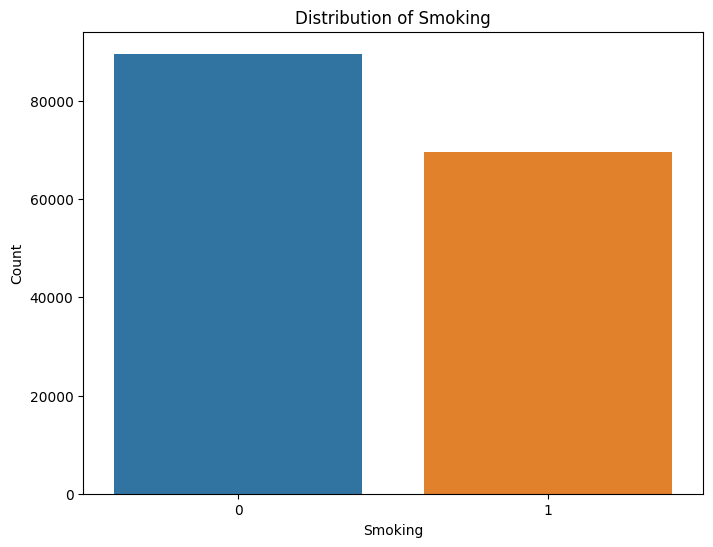

In [7]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'smoking', data = train)

plt.title('Distribution of Smoking')
plt.xlabel('Smoking')
plt.ylabel('Count')
plt.show()

## Preprocessing

In [8]:
X = train.drop(['id', 'smoking'], axis = 1)
Y = train['smoking']

In [9]:
numericalColumnsX = X.select_dtypes(include = ['float64', 'int64']).columns
numericalColumnTest = test.select_dtypes(include = ['float64', 'int64']).columns

Scaler = StandardScaler()
X[numericalColumnsX] = Scaler.fit_transform(X[numericalColumnsX])
test = test.drop('id', axis = 1)
test = Scaler.transform(test)

## Defining and training our model

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [11]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4] 
}
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state = 42), 
                           param_grid = param_grid, 
                           scoring = 'roc_auc', 
                           cv = 5, 
                           verbose = 1,
                           n_jobs = -1)

grid_search.fit(X_train, Y_train)

best_score = grid_search.best_score_
print(f"Best ROC AUC Score: {best_score:.4f}")

best_rf_model = grid_search.best_estimator_
predictions = best_rf_model.predict_proba(test)[:, 1]


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best ROC AUC Score: 0.8606


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [12]:
#model = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=5)
#model.fit(X, Y)
#predictions_train = model.predict_proba(X_train)[:, 1]
#predictions_val = model.predict_proba(X_val)[:, 1]

#roc_auc_train = roc_auc_score(Y_train, predictions_train)
#roc_auc_val = roc_auc_score(Y_val, predictions_val)

#print(f"Training ROC AUC Score: {roc_auc_train:.4f}")
#print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

#predictions = model.predict_proba(test)[:, 1]

In [13]:

smth = pd.read_csv("/kaggle/input/tss24-competition-3/test.csv")

Submission = pd.DataFrame({
    'id' : smth['id'], 
    'smoking' : predictions
})

Submission.to_csv('Submission.csv', index = False)
print("Submission file created successfully.")


Submission file created successfully.
